In [1]:
!pip install qiskit-machine-learning

from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2, PauliFeatureMap
from qiskit.circuit import ParameterVector
from functools import reduce
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

algorithm_globals.random_seed = 12345

In [2]:
train_features = []
train_labels = []

test_ = []

with open('HW3-Q5-data.txt', 'r') as file:
    for line in file:
        values = line.strip().split()
        features = [float(value) for value in values[:-1]]  
        label = int(values[-1])  
        train_features.append(features)
        train_labels.append(label)
        
with open('HW3-Q5-data-test.txt', 'r') as file:
    for line in file:
        values = line.strip().split()
        features = [float(value) for value in values]  
        test_.append(features)
        
train_features = np.array(train_features)
train_labels = np.array(train_labels)

train_features, test_features, train_labels, test_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [3]:
qubits = 4     
repeats = 2

def get_custom_map(entanglement):
    
    if(entanglement=='full'):
        x = ParameterVector('x', length=qubits)
        custom_map = QuantumCircuit(qubits)

        for _ in range(repeats):
            for i in range(qubits):
                custom_map.rx(x[i], i)
            for i in range(qubits):
                custom_map.ry(x[i], i)
            for i in range(qubits):
                for j in range(i + 1, qubits):
                    custom_map.p(x[i] * x[j], j)
                    custom_map.cx(i, j)
            custom_map.barrier()
            
        return custom_map
        
    if(entanglement=='linear'):
        x = ParameterVector('x', length=qubits)
        custom_map = QuantumCircuit(qubits)

        for _ in range(repeats):
            for i in range(qubits):
                custom_map.ry(x[i], i)
            for i in range(qubits):
                custom_map.rz(x[i], i)
            for i in range(qubits):
                if (i != qubits -1):
                    custom_map.cx(i, i+1)
                for j in range(i + 1, qubits):
                    custom_map.p(x[i] * x[j], j)
            custom_map.barrier()
            
        return custom_map
        
    if(entanglement=='none'):
        x = ParameterVector('x', length=qubits)
        custom_map = QuantumCircuit(qubits)

        for _ in range(repeats):
            for i in range(qubits):
                custom_map.rx(x[i], i)
            for i in range(qubits):
                custom_map.rz(x[i], i)
            for i in range(qubits):
                for j in range(i + 1, qubits):
                    custom_map.p(x[i] * x[j], j)
            custom_map.barrier()
            
        return custom_map
    
    return None

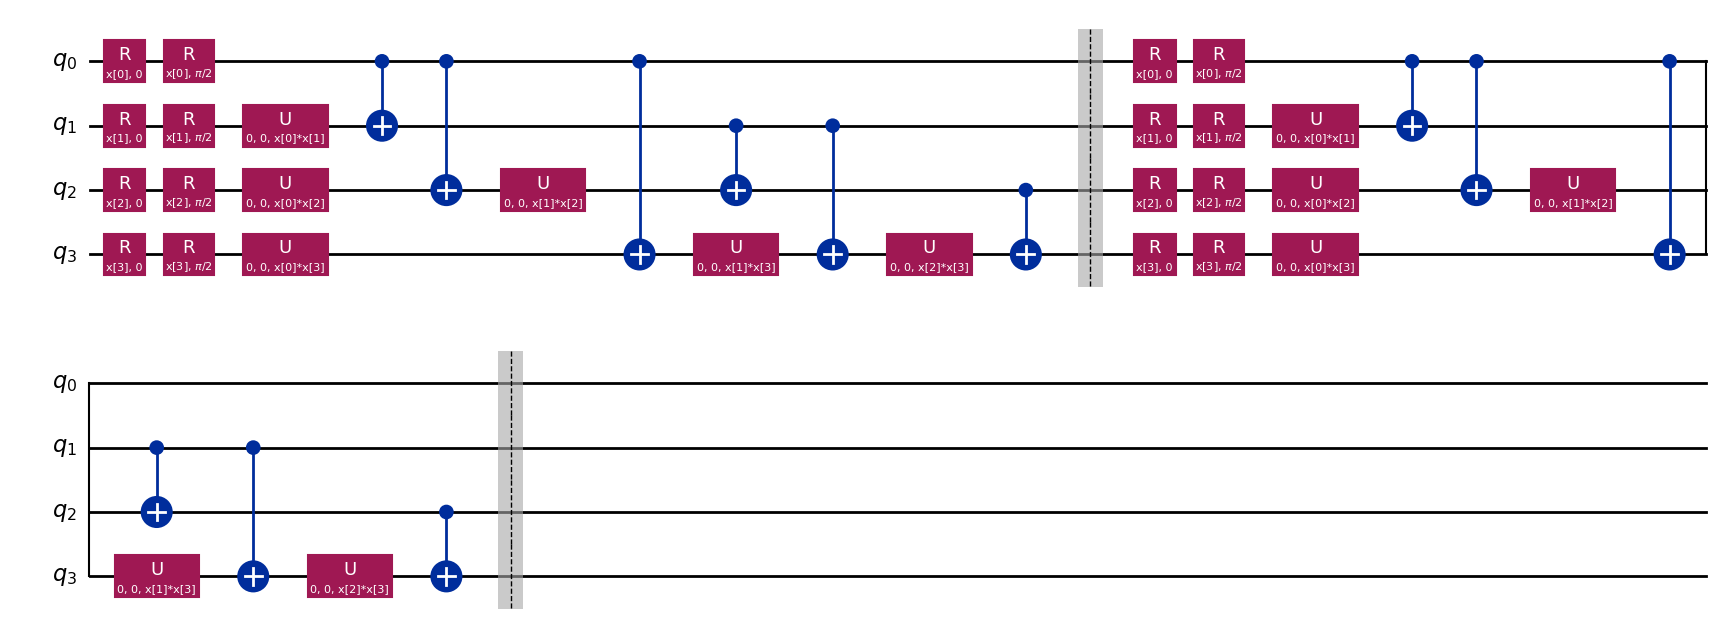

In [4]:
custom_map = get_custom_map('full')
custom_map.decompose().draw()    

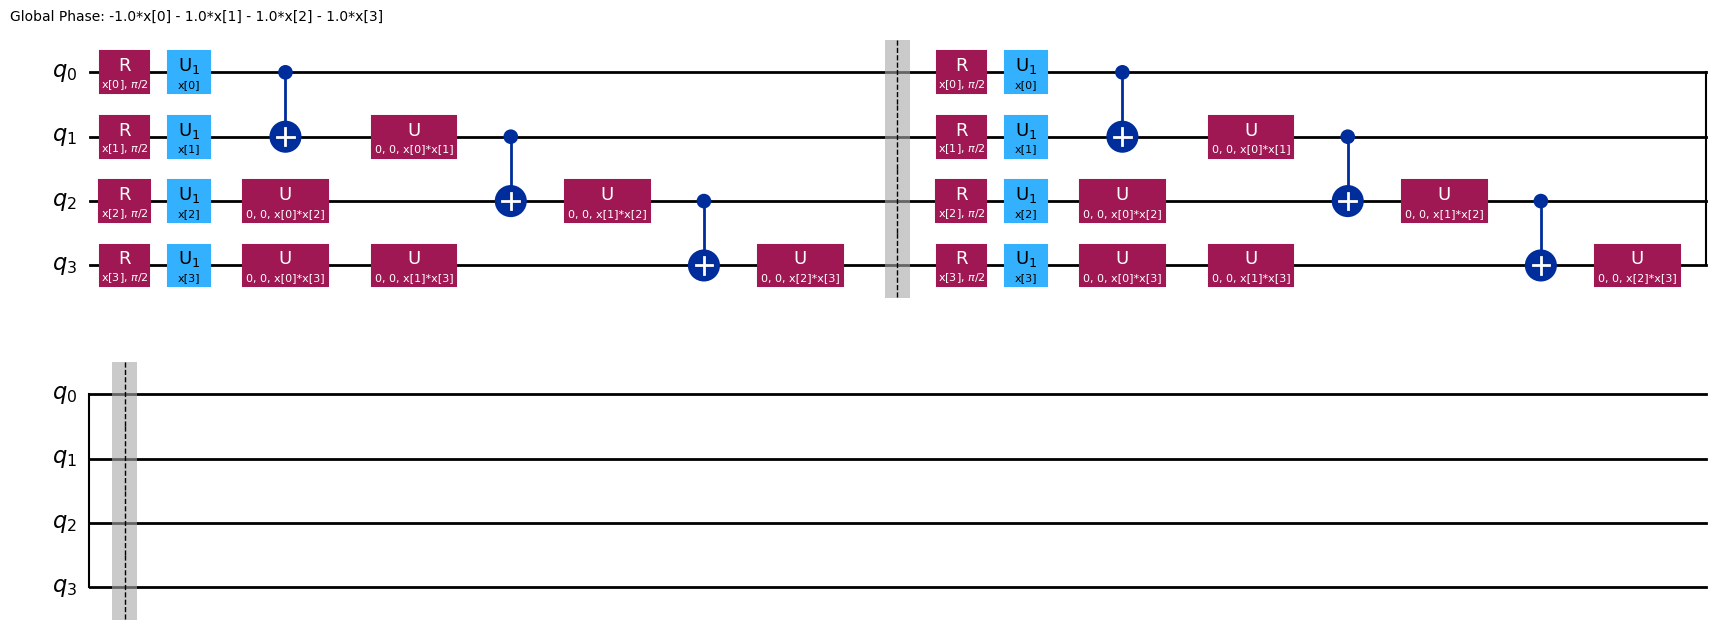

In [5]:
custom_map = get_custom_map('linear')
custom_map.decompose().draw()    

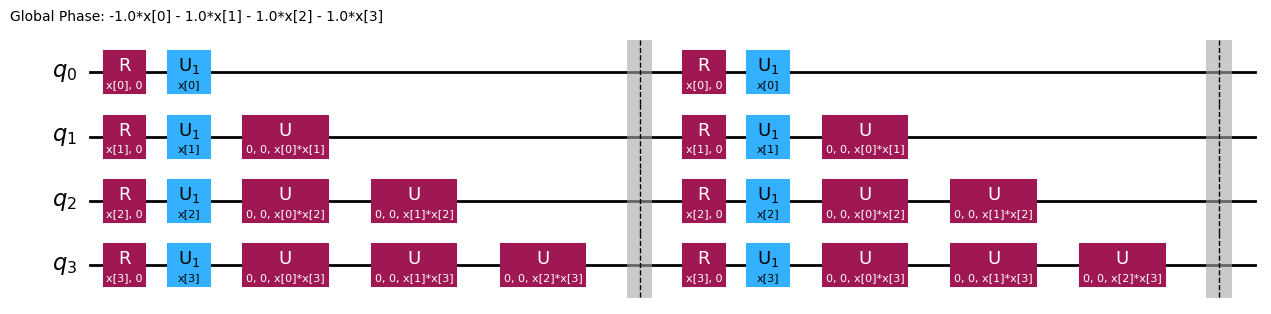

In [6]:
custom_map = get_custom_map('none')
custom_map.decompose().draw()    

In [7]:
entanglement =  ['full', 'linear', 'none']

for ent in entanglement:
    
    print("Running for entaglement type:", ent)
    custom_map = get_custom_map(ent)

    sampler = Sampler()
    fidelity = ComputeUncompute(sampler=sampler)
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=custom_map)
    print("Kernel made, starting fitting...")

    from sklearn.svm import SVC
    svc = SVC(kernel=kernel.evaluate)
    svc.fit(train_features, train_labels)
    print("Fitting Done, starting testing...")

    score = svc.score(test_features, test_labels)
    print(f"Kernel classification test score: {score}")
    print()

Running for entaglement type: full
Kernel made, starting fitting...
Fitting Done, starting testing...
Kernel classification test score: 1.0

Running for entaglement type: linear
Kernel made, starting fitting...
Fitting Done, starting testing...
Kernel classification test score: 1.0

Running for entaglement type: none
Kernel made, starting fitting...
Fitting Done, starting testing...
Kernel classification test score: 1.0



In [8]:
predictions = svc.predict(test_)
print("Predictions:", predictions)

Predictions: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]
